In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression,  RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,classification_report, precision_recall_curve

sys.path.append("..")

from models.ClassificationMetrics import myBinaryConfusionMatrix, myClassificationReport
from models.kneighbors import kNN

# Загрузка датасета

Инициализируем датасет 

In [2]:
data = pd.read_csv('../data/weatherAUS.csv')
pd.set_option('display.max_columns', 30)
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Заметим, что в датасете есть пропуски. Рассмотрим процент пропусков в каждом из столбцов:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64

# Подготовка данных

## Обработка пропущенных значений

Проверим число явных дубликатов:

In [5]:
data.duplicated().sum()

0

Поскольку процент пропусков в Sunshine, Evaporation, Cloud3pm, Cloud9am несоразмерно велик по сравнению с любым другим столбцом, рассмотрим их отдельно. Поэтому для начала заполним модой данные в остальных столбцах, кроме RainTomorrow. Все пропуски в нем удалим для достоверности целевого признака.

In [6]:
data.dropna(inplace = True, subset=['RainTomorrow'])

In [7]:
columns = ['Pressure9am', 'Pressure3pm', 'WindDir9am', 'WindGustDir',      
            'WindGustSpeed', 'Humidity3pm', 'WindDir3pm', 'Temp3pm',   
            'Rainfall', 'RainToday', 'WindSpeed3pm', 'Humidity9am', 
            'Temp9am', 'WindSpeed9am', 'MinTemp',  'MaxTemp']  

for column in columns:
    mode = data[column].mode().iat[0]
    data[column].fillna(mode, inplace = True)

In [8]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Sunshine         47.692924
Evaporation      42.789026
Cloud3pm         40.152469
Cloud9am         37.735332
Date              0.000000
Humidity9am       0.000000
RainToday         0.000000
Temp3pm           0.000000
Temp9am           0.000000
Pressure3pm       0.000000
Pressure9am       0.000000
Humidity3pm       0.000000
WindSpeed9am      0.000000
WindSpeed3pm      0.000000
Location          0.000000
WindDir3pm        0.000000
WindDir9am        0.000000
WindGustSpeed     0.000000
WindGustDir       0.000000
Rainfall          0.000000
MaxTemp           0.000000
MinTemp           0.000000
RainTomorrow      0.000000
dtype: float64

Рассмотрим гистограммы, чтобы оценить результат действий:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        142193 non-null  float64
 3   MaxTemp        142193 non-null  float64
 4   Rainfall       142193 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    142193 non-null  object 
 8   WindGustSpeed  142193 non-null  float64
 9   WindDir9am     142193 non-null  object 
 10  WindDir3pm     142193 non-null  object 
 11  WindSpeed9am   142193 non-null  float64
 12  WindSpeed3pm   142193 non-null  float64
 13  Humidity9am    142193 non-null  float64
 14  Humidity3pm    142193 non-null  float64
 15  Pressure9am    142193 non-null  float64
 16  Pressure3pm    142193 non-null  float64
 17  Cloud9am       88536 non-null   fl

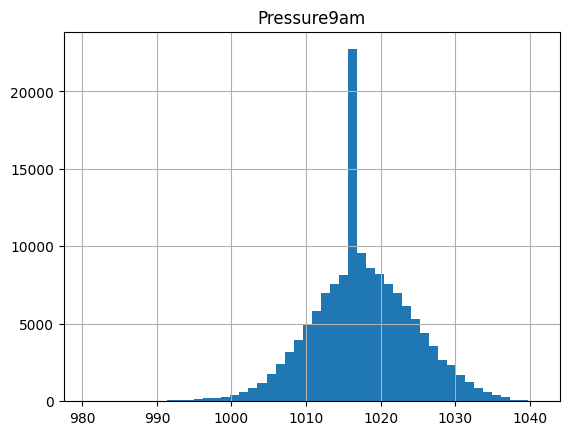

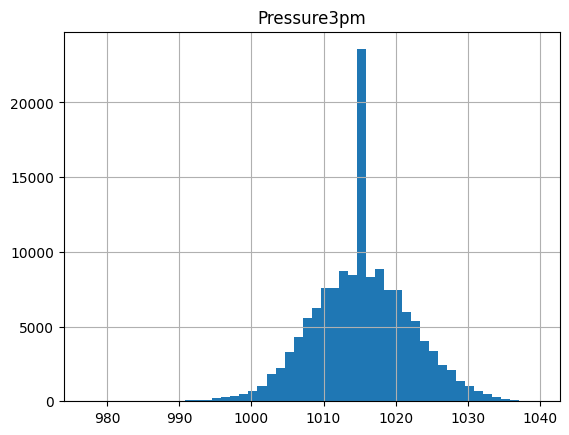

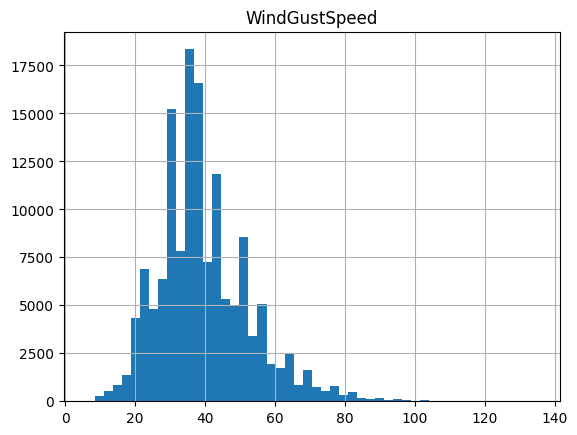

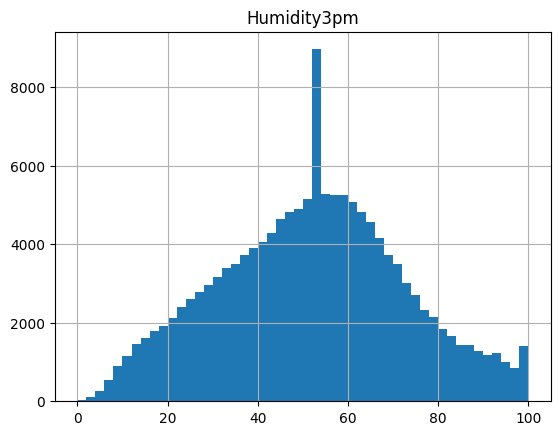

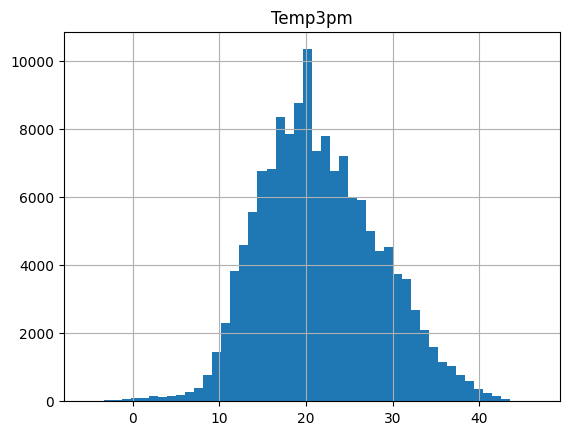

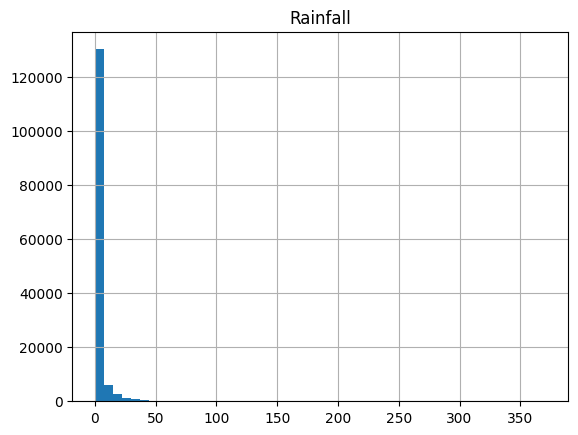

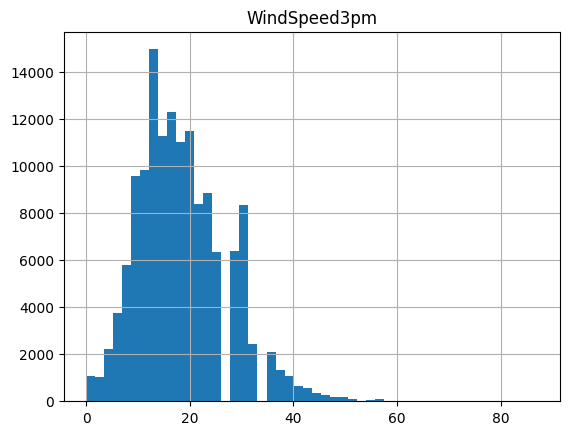

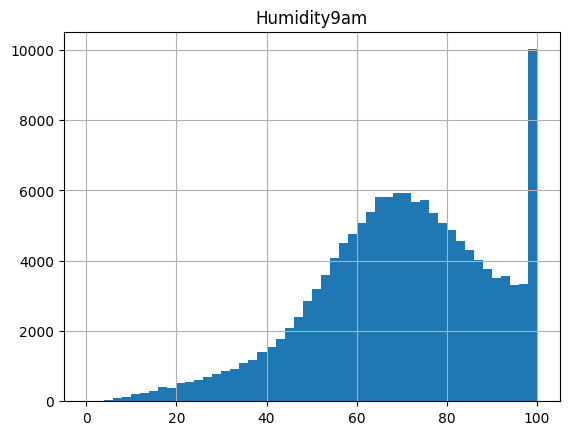

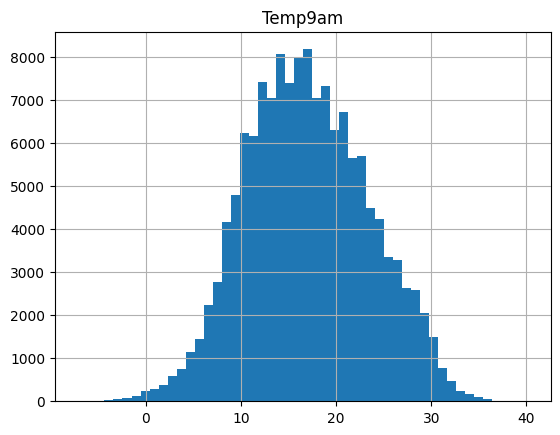

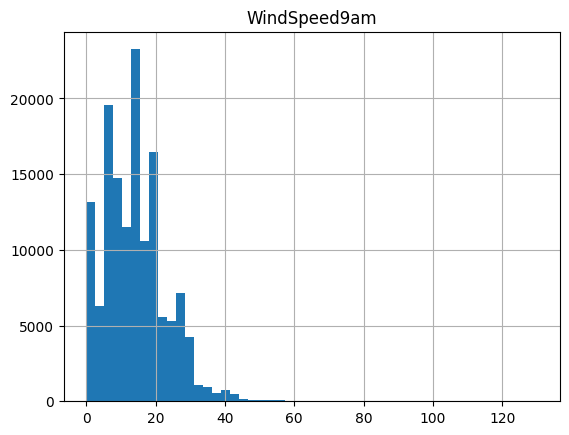

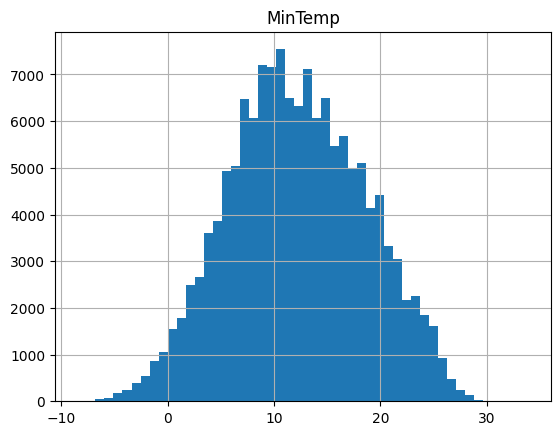

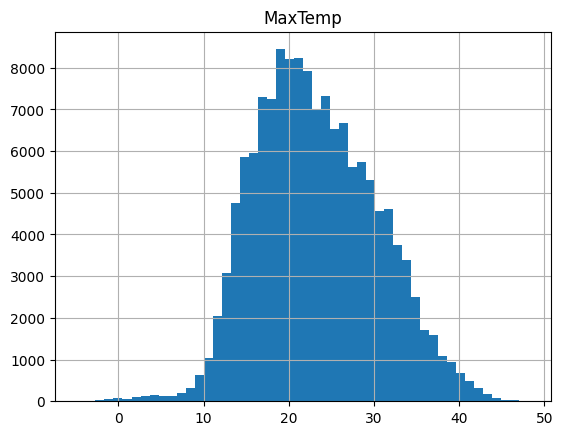

In [10]:
columns.remove('WindGustDir')
columns.remove('WindDir9am')
columns.remove('WindDir3pm')
columns.remove('RainToday')

for column in columns:
    data.hist(column, bins = 50)

Аномалии возникли в Pressure9am, Pressure3pm, Humindity3pm, Rainfall, Humindity9am. Можно заметить, что без них распределение близко к нормальному. В то же время удаление проблемных данных приведет к значительному уменьшению размера выборки. Поэтому принято решение оставить датасет в текущем виде.

Рассмотрим  Sunshine, Evaporation, Cloud3pm, Cloud9am:

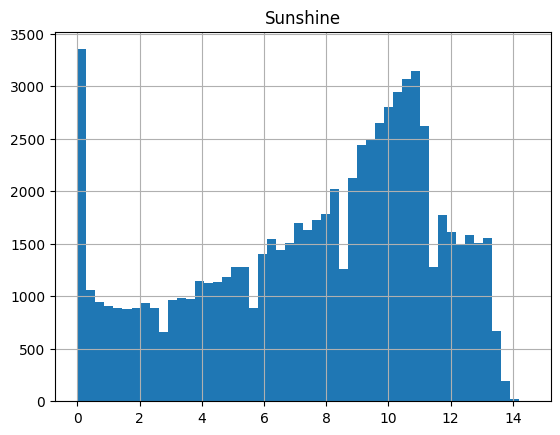

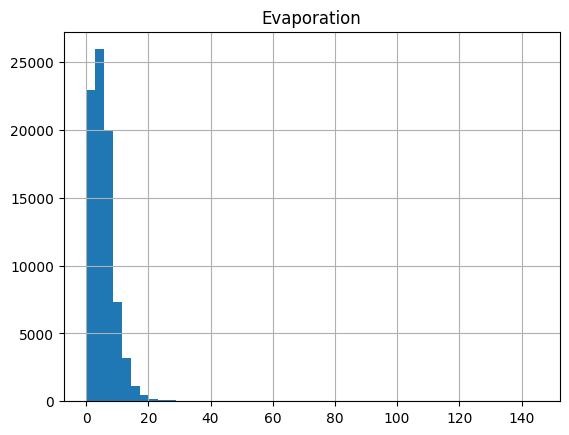

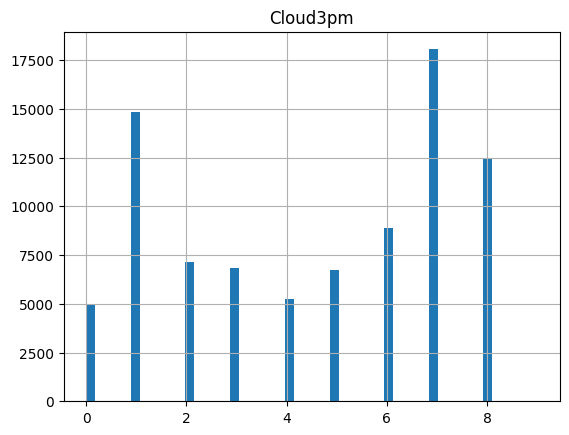

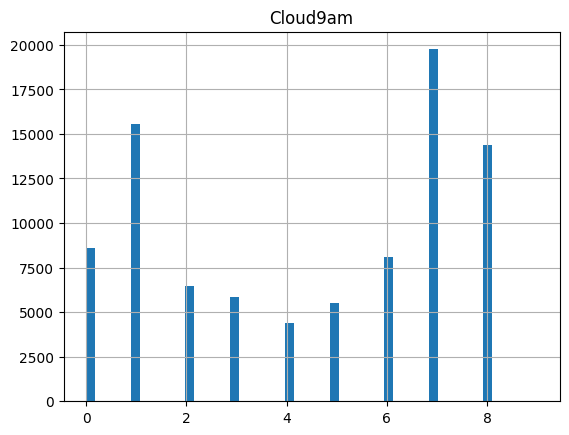

In [11]:
columns = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
for column in columns:
    data.hist(column, bins = 50)

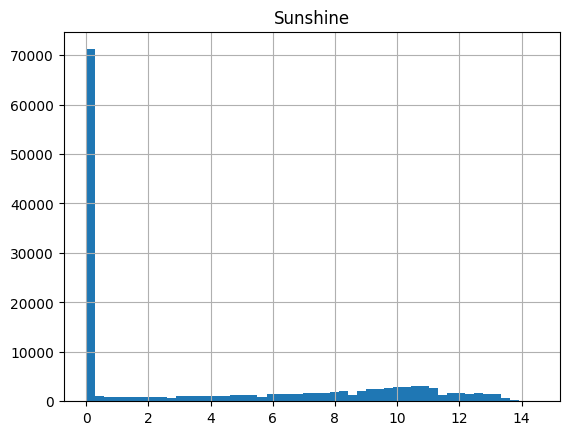

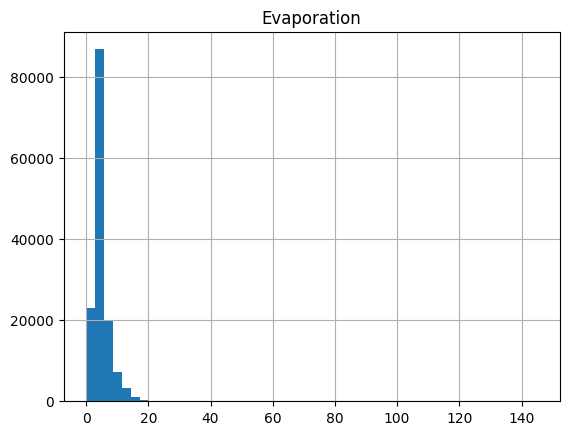

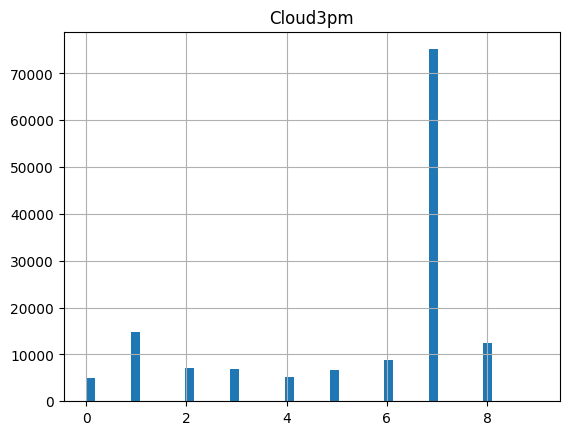

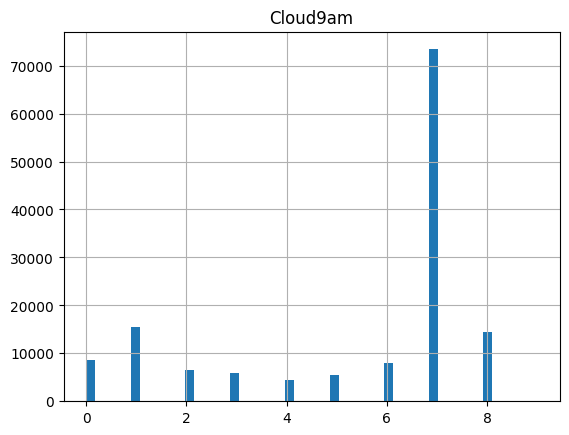

In [12]:
for column in columns:
    mode = data[column].mode().iat[0]
    data[column].fillna(mode, inplace = True)

for column in columns:
    data.hist(column, bins = 50)

Поскольку заполнение пропусков в столбце Sunshine сильно искажает исходный вид данных, собирая результаты большинства наблюдений в окрестности нуля (т.е. делая почти все дни в Австралии пасмурными), это сделает признак малоинформативным. В то же время общее распределение данных в Evaporation сильно не меняется, а Cloud3pm и Cloud9am это происходит в целом умеренно (другие данные хорошо различимы на фоне моды). Поэтому от столбца Sunshine проще всего избавиться.

In [13]:
data.drop(['Sunshine'], axis=1, inplace = True)

In [14]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Date             0.0
Location         0.0
RainToday        0.0
Temp3pm          0.0
Temp9am          0.0
Cloud3pm         0.0
Cloud9am         0.0
Pressure3pm      0.0
Pressure9am      0.0
Humidity3pm      0.0
Humidity9am      0.0
WindSpeed3pm     0.0
WindSpeed9am     0.0
WindDir3pm       0.0
WindDir9am       0.0
WindGustSpeed    0.0
WindGustDir      0.0
Evaporation      0.0
Rainfall         0.0
MaxTemp          0.0
MinTemp          0.0
RainTomorrow     0.0
dtype: float64

## Кодирование категориальных признаков

In [15]:
cat_columns = ['Location', 'RainToday', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainTomorrow']

In [16]:
for column in cat_columns:
    print(data[column].unique())

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
['No' 'Yes']
['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' 'NE']
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'N' 'SSW' 'WSW' 'ESE' 'E' 'NW'
 'WNW' 'NNE']
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW']
['No' 'Yes']


Применим к Location и всем Wind... порядковое кодирование

In [17]:
ordinal_features = ['Location', 'WindDir9am', 'WindGustDir', 'WindDir3pm', 'RainToday']
ordinal_encoder = OrdinalEncoder()

ct = ColumnTransformer(transformers=[
     ('ord', ordinal_encoder, ordinal_features)
])

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(data)
encoded_features.head(20)

,ord__Location,ord__WindDir9am,ord__WindGustDir,ord__WindDir3pm,ord__RainToday
0,2.0,13.0,13.0,14.0,0.0
1,2.0,6.0,14.0,15.0,0.0
2,2.0,13.0,15.0,15.0,0.0
3,2.0,9.0,4.0,0.0,0.0
4,2.0,1.0,13.0,7.0,0.0
5,2.0,13.0,14.0,13.0,0.0
6,2.0,12.0,13.0,13.0,0.0
7,2.0,10.0,13.0,13.0,0.0
8,2.0,9.0,6.0,7.0,0.0
9,2.0,8.0,13.0,10.0,1.0


In [18]:
encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ord__Location     142193 non-null  float64
 1   ord__WindDir9am   142193 non-null  float64
 2   ord__WindGustDir  142193 non-null  float64
 3   ord__WindDir3pm   142193 non-null  float64
 4   ord__RainToday    142193 non-null  float64
dtypes: float64(5)
memory usage: 6.5 MB


Закодируем целевой признак и добавим в фрейм к уже обработанным значениям

In [19]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(data['RainTomorrow'])
encoded_data = encoded_features.assign(RainTomorrow=encoded_label)
encoded_data.head()

,ord__Location,ord__WindDir9am,ord__WindGustDir,ord__WindDir3pm,ord__RainToday,RainTomorrow
0,2.0,13.0,13.0,14.0,0.0,0
1,2.0,6.0,14.0,15.0,0.0,0
2,2.0,13.0,15.0,15.0,0.0,0
3,2.0,9.0,4.0,0.0,0.0,0
4,2.0,1.0,13.0,7.0,0.0,0


In [20]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ord__Location     142193 non-null  float64
 1   ord__WindDir9am   142193 non-null  float64
 2   ord__WindGustDir  142193 non-null  float64
 3   ord__WindDir3pm   142193 non-null  float64
 4   ord__RainToday    142193 non-null  float64
 5   RainTomorrow      142193 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 7.1 MB


Удалим обработанные ранее столбцы из исходного фрейма

In [21]:
data.drop(cat_columns, axis = 1, inplace = True)
data.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2008-12-01,13.4,22.9,0.6,4.0,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8
1,2008-12-02,7.4,25.1,0.0,4.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3
2,2008-12-03,12.9,25.7,0.0,4.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2
3,2008-12-04,9.2,28.0,0.0,4.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5
4,2008-12-05,17.5,32.3,1.0,4.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   WindGustSpeed  142193 non-null  float64
 6   WindSpeed9am   142193 non-null  float64
 7   WindSpeed3pm   142193 non-null  float64
 8   Humidity9am    142193 non-null  float64
 9   Humidity3pm    142193 non-null  float64
 10  Pressure9am    142193 non-null  float64
 11  Pressure3pm    142193 non-null  float64
 12  Cloud9am       142193 non-null  float64
 13  Cloud3pm       142193 non-null  float64
 14  Temp9am        142193 non-null  float64
 15  Temp3pm        142193 non-null  float64
dtypes: float64(15), object(1)
memory usage: 18.4+ MB


Произведем конкатенацию столбцов исходного фрейма и фрейма с обработанными данными

In [23]:
data = pd.concat([data.reset_index(drop = True), encoded_data.reset_index(drop = True)], axis = 1)
data.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,ord__Location,ord__WindDir9am,ord__WindGustDir,ord__WindDir3pm,ord__RainToday,RainTomorrow
0,2008-12-01,13.4,22.9,0.6,4.0,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,2.0,13.0,13.0,14.0,0.0,0
1,2008-12-02,7.4,25.1,0.0,4.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,2.0,6.0,14.0,15.0,0.0,0
2,2008-12-03,12.9,25.7,0.0,4.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,2.0,13.0,15.0,15.0,0.0,0
3,2008-12-04,9.2,28.0,0.0,4.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,2.0,9.0,4.0,0.0,0.0,0
4,2008-12-05,17.5,32.3,1.0,4.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2.0,1.0,13.0,7.0,0.0,0


Поскольку столбец с датой неинформативен в своем исходном виде, преобразуем значения в соответствующие месяца

In [24]:
data['Date'] = pd.Series(pd.to_datetime(data['Date'].values).month)

In [25]:
data['Date'].unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [26]:
data.head(30)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,ord__Location,ord__WindDir9am,ord__WindGustDir,ord__WindDir3pm,ord__RainToday,RainTomorrow
0,12,13.4,22.9,0.6,4.0,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,2.0,13.0,13.0,14.0,0.0,0
1,12,7.4,25.1,0.0,4.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,2.0,6.0,14.0,15.0,0.0,0
2,12,12.9,25.7,0.0,4.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,2.0,13.0,15.0,15.0,0.0,0
3,12,9.2,28.0,0.0,4.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,2.0,9.0,4.0,0.0,0.0,0
4,12,17.5,32.3,1.0,4.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2.0,1.0,13.0,7.0,0.0,0
5,12,14.6,29.7,0.2,4.0,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,7.0,7.0,20.6,28.9,2.0,13.0,14.0,13.0,0.0,0
6,12,14.3,25.0,0.0,4.0,50.0,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,7.0,18.1,24.6,2.0,12.0,13.0,13.0,0.0,0
7,12,7.7,26.7,0.0,4.0,35.0,6.0,17.0,48.0,19.0,1013.4,1010.1,7.0,7.0,16.3,25.5,2.0,10.0,13.0,13.0,0.0,0
8,12,9.7,31.9,0.0,4.0,80.0,7.0,28.0,42.0,9.0,1008.9,1003.6,7.0,7.0,18.3,30.2,2.0,9.0,6.0,7.0,0.0,1
9,12,13.1,30.1,1.4,4.0,28.0,15.0,11.0,58.0,27.0,1007.0,1005.7,7.0,7.0,20.1,28.2,2.0,8.0,13.0,10.0,1.0,0


# Разделение выборки

Выделим столбец с целевым признаком, 

In [27]:
y = data['RainTomorrow']
X = data.drop(['RainTomorrow'], axis=1)

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
142188    0
142189    0
142190    0
142191    0
142192    0
Name: RainTomorrow, Length: 142193, dtype: int32

Проверим уровень дизбаланса между классами 

In [29]:
yes = data[data['RainTomorrow'] == 1]['RainTomorrow'].count()


In [30]:
no = data['RainTomorrow'].count() - yes

In [31]:
print(f'{round((yes/no)*100)}%')

29%


Разделим датасеты на тренировочные и тестовые выборки, используя ресемплирование для train

In [32]:
nm = NearMiss()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((113754, 21), (113754,), (28439, 21), (28439,))

In [35]:
X_train, y_train = nm.fit_resample(X_train, y_train.ravel())

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50972, 21), (50972,), (28439, 21), (28439,))

# Масштабирование

In [37]:
scaler = StandardScaler()

In [38]:
scaler.fit(X_train)

StandardScaler()

In [39]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_train

array([[-0.74564984, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       [-1.05267752, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       [-1.05267752, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       ...,
       [ 0.78948856, -1.16110537,  0.25753792, ..., -0.92330169,
        -0.60665652, -0.68750886],
       [ 1.7105716 ,  1.56634899,  1.13370677, ..., -0.48406426,
        -1.0649339 , -0.68750886],
       [-0.74564984, -0.04817859, -0.61863093, ...,  1.05326675,
         1.22645304,  1.4545267 ]])

# Создание и обучение моделей классификации

Функции для вывода метрик

In [41]:
def show_metrics(y_test, predict):
    print(classification_report(y_test, predict))    

def show_roc(X_test, y_test, model):
    %matplotlib inline
    
    y_scores = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    fig = plt.figure(figsize=(6, 6))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print(f'AUC: {roc_auc_score(y_test, y_scores[:,1])}')

def show_con_mat(y_test, predict):
    print(confusion_matrix(y_test, predict))

## Логистическая регрессия

In [42]:
params = {'C': np.arange(0.01, 1, 0.1)}

In [43]:
lr_optimal = GridSearchCV(LogisticRegression(), params).fit(X_train, y_train)
lr_optimal.best_params_

{'C': 0.11}

In [44]:
lr = LogisticRegression(C = lr_optimal.best_params_['C'])
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

In [45]:
show_con_mat(y_test, predict)

[[17351  4697]
 [ 1907  4484]]


In [46]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     22048
           1       0.49      0.70      0.58      6391

    accuracy                           0.77     28439
   macro avg       0.69      0.74      0.71     28439
weighted avg       0.81      0.77      0.78     28439

f1_score: 0.5759054713588492


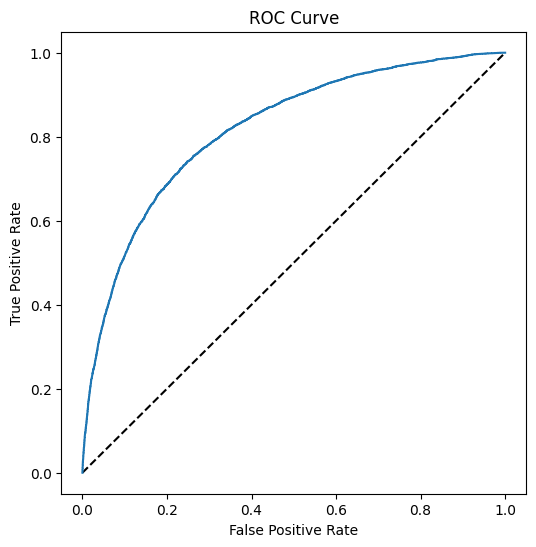

AUC: 0.8185306254327622


In [47]:
show_roc(X_test, y_test, lr)

Видим, что модель предсказывает реальные значения хорошо: ROC кривая по форме близка к идеальному варианту, метрики для первого класса достаточно высоки, а для второго в пределах адекватных.

## Метод k ближайших соседей

In [48]:
params = {'n_neighbors': np.arange(1, 15, 2)}
knn_optimal = GridSearchCV(KNeighborsClassifier(), params).fit(X_train, y_train)
knn_optimal.best_params_

{'n_neighbors': 13}

In [49]:
knn = KNeighborsClassifier(n_neighbors = knn_optimal.best_params_['n_neighbors'], weights = 'distance')

In [50]:
knn.fit(X_train, y_train)
predict = knn.predict(X_test)

In [51]:
show_con_mat(y_test, predict)

[[17167  4881]
 [ 2317  4074]]


In [52]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     22048
           1       0.45      0.64      0.53      6391

    accuracy                           0.75     28439
   macro avg       0.67      0.71      0.68     28439
weighted avg       0.79      0.75      0.76     28439

f1_score: 0.5309526912550502


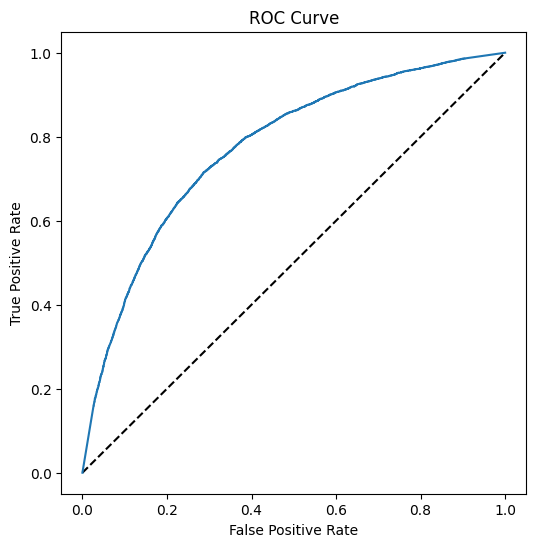

AUC: 0.7747313957070436


In [53]:
show_roc(X_test, y_test, knn)

Из значений метрик видно, что kNN, использующий евклидову метрику (с поиском k по сетке) справляется с задачей классификации немного хуже, чем логистическая регрессия.

## Наивный байесовский классификатор

### Gaussian

In [54]:
params = {'var_smoothing': np.arange(0, 0.01, 1)}
gs_nb_optimal = GridSearchCV(GaussianNB(), params).fit(X_train, y_train)
gs_nb_optimal.best_params_

{'var_smoothing': 0.0}

In [55]:
gs_nb = GaussianNB()
gs_nb.fit(X_train, y_train)

GaussianNB()

In [56]:
predict = gs_nb.predict(X_test)

In [57]:
show_con_mat(y_test, predict)

[[17128  4920]
 [ 2573  3818]]


In [58]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     22048
           1       0.44      0.60      0.50      6391

    accuracy                           0.74     28439
   macro avg       0.65      0.69      0.66     28439
weighted avg       0.77      0.74      0.75     28439

f1_score: 0.5047260228699848


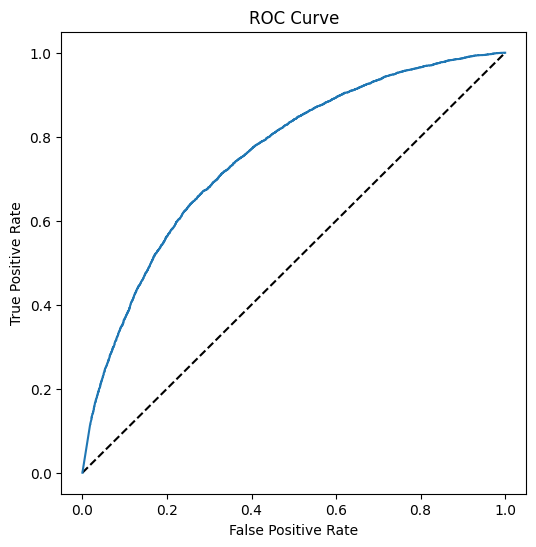

AUC: 0.7561118836834908


In [59]:
show_roc(X_test, y_test, gs_nb)

Из метрик видно, что гауссовский наивный байес справился с задачей хуже всех остальных рассмотренных классификаторов.

## SVM

In [63]:
params = {'C': np.arange(0.01, 0.1, 1), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'gamma': ['scale', 'auto']}
svc_optimal = GridSearchCV(SVC(), params).fit(X_train, y_train)
svc_optimal.best_params_

{'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
#{'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [64]:
c = svc_optimal.best_params_['C']
gamma = svc_optimal.best_params_['gamma']
kernel = svc_optimal.best_params_['kernel']

In [70]:
svc = SVC(C = c, gamma = gamma, kernel = kernel, probability=True)
svc.fit(X_train, y_train)

SVC(C=0.01, probability=True)

In [72]:
predict = svc.predict(X_test)

In [73]:
show_con_mat(y_test, predict)

[[15169  6879]
 [ 1850  4541]]


In [74]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.89      0.69      0.78     22048
           1       0.40      0.71      0.51      6391

    accuracy                           0.69     28439
   macro avg       0.64      0.70      0.64     28439
weighted avg       0.78      0.69      0.72     28439

f1_score: 0.509909606422997


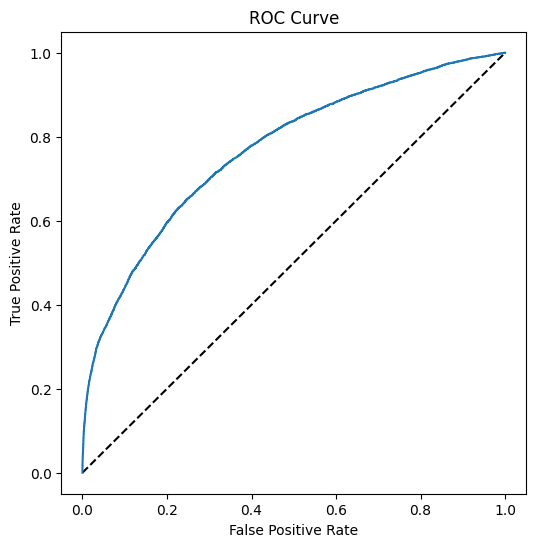

AUC: 0.7698880278337257


In [75]:
show_roc(X_test, y_test, svc)

Исходя из метрик, модель RBF заметно не улучшила результаты классификации.

# Построение итоговой модели классификаторов

In [79]:
classifiers = {
    'Logistic Regression': LogisticRegression(C = 0.11),
    'Naive Bayes' : GaussianNB(),
    'SVC': SVC(kernel='rbf', C= 0.01, gamma = 'scale', probability=True),
    'KNN classifier': KNeighborsClassifier(n_neighbors=13, metric='minkowski', weights='distance')
}

In [80]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Logistic Regression: 76.8% 
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     22048
           1       0.49      0.70      0.58      6391

    accuracy                           0.77     28439
   macro avg       0.69      0.74      0.71     28439
weighted avg       0.81      0.77      0.78     28439

Accuracy (train) for Naive Bayes: 73.7% 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     22048
           1       0.44      0.60      0.50      6391

    accuracy                           0.74     28439
   macro avg       0.65      0.69      0.66     28439
weighted avg       0.77      0.74      0.75     28439

Accuracy (train) for SVC: 69.3% 
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     22048
           1       0.40      0.71      0.51      6391

    accuracy                           0.69     28439
   ma

В результате, наилучшие метрики имеет модель логистической регрессии.

## Собственные метрики

In [ ]:
n_classifiers = len(classifiers)
con_mtx = myBinaryConfusionMatrix(y_test.values, y_pred)
print(con_mtx)
print()

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))

    y_pred = classifier.predict(X_test)
    myClassificationReport(y_test.values, y_pred)
    print()

# Реализация kNN

In [225]:
my_X_train = X_train[5000:50000:100]
my_y_train = y_train[5000:50000:100]
my_X_test = X_test[20000:30000:50]
my_y_test = y_test[20000:30000:50]

In [226]:
my_knn = kNN(3)

In [227]:
my_knn.fit(my_X_train, my_y_train)
predict = my_knn.predict(my_X_test)

In [229]:
show_con_mat(my_y_test, predict)

[[83 45]
 [13 28]]


In [228]:
print(predict)

[0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1
 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0
 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1]


In [231]:
show_metrics(my_y_test, predict)

              precision    recall  f1-score   support

           0       0.86      0.65      0.74       128
           1       0.38      0.68      0.49        41

    accuracy                           0.66       169
   macro avg       0.62      0.67      0.62       169
weighted avg       0.75      0.66      0.68       169

f1_score: 0.4912280701754387


# Задание

Какова вероятность отправиться на прогулку если идёт дождь, при наличии следующих наблюдений?

In [233]:
data = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]

In [234]:
data = pd.DataFrame(data, columns=['weather', 'iswalking'])
data

,weather,iswalking
0,солнечно,True
1,снег,False
2,облачно,False
3,дождь,False
4,солнечно,True
5,снег,False
6,облачно,True
7,снег,False
8,солнечно,False
9,облачно,True


In [235]:
rain_data = data[data['weather'] == 'дождь']

In [239]:
prob = len(rain_data[rain_data['iswalking'] == True])/len(rain_data)

In [240]:
print(prob)

0.3333333333333333
